# Import Packages

In [1]:
# core and utility packages
import pandas as pd
import numpy as np
import itertools

# visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

# modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# keras
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras import models

np.random.seed(2)

Using TensorFlow backend.


# 2. Data preparation
## 2.1 Load data

In [2]:
# Load the data
train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")

train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


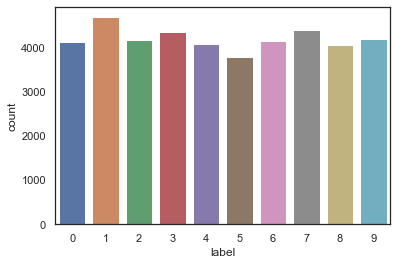

In [3]:
y_train = train["label"]

# Drop 'label' column
x_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(y_train)

## 2.2 Normalization

In [4]:
# Normalize the data
x_train = x_train / 255.0
test = test / 255.0

## 2.3 Reshape

In [5]:
x_train.shape


(42000, 784)

In [6]:
test.shape

(28000, 784)

In [7]:

x_train = x_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
x_train.shape

(42000, 28, 28, 1)

## 2.4 Label encoding

In [8]:

y_train_value = y_train 
y_train = to_categorical(y_train, num_classes = 10) 
y_train.shape


(42000, 10)

## 2.5 Split training and valdiation set 

In [9]:
# Set the random seed
random_seed = 2

In [10]:
# Split the train and the validation set for the fitting
x_train, X_val, y_train, Y_val = train_test_split(x_train, y_train , test_size = 0.1, random_state=random_seed)
x_train.shape

(37800, 28, 28, 1)

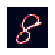

In [11]:
# preview the images first
plt.figure(figsize=(8,5))

x, y = 10, 4
for i in range(1):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i].reshape((28,28)),interpolation='nearest')
    plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

# 3. CNN
## 3.1 Define the model

In [12]:

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 16)        2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 32)       

## 3.2 Complie the model with loss function and optimizer


In [13]:
# Define the optimizer
optimizer = Adam(lr=1e-4)

In [14]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

## 3.3 Data augmentation 

In [16]:
#to prevent overfitting

datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1)  # randomly shift images vertically (fraction of total height)

datagen.fit(x_train)

## 3.4 Fit the model

In [17]:
# Set a learning rate annealer
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

# Turn epochs to 30 to get 0.9967 accuracy
epochs = 30 
batch_size = 86

In [18]:
# Fit the model
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[annealer])

Epoch 1/30
 - 68s - loss: 0.4486 - accuracy: 0.8576 - val_loss: 0.1355 - val_accuracy: 0.9574
Epoch 2/30
 - 67s - loss: 0.1582 - accuracy: 0.9528 - val_loss: 0.0600 - val_accuracy: 0.9805
Epoch 3/30
 - 70s - loss: 0.1206 - accuracy: 0.9652 - val_loss: 0.0552 - val_accuracy: 0.9810
Epoch 4/30
 - 73s - loss: 0.1023 - accuracy: 0.9684 - val_loss: 0.0422 - val_accuracy: 0.9876
Epoch 5/30
 - 71s - loss: 0.0858 - accuracy: 0.9751 - val_loss: 0.0345 - val_accuracy: 0.9902
Epoch 6/30
 - 72s - loss: 0.0761 - accuracy: 0.9765 - val_loss: 0.0307 - val_accuracy: 0.9912
Epoch 7/30
 - 76s - loss: 0.0727 - accuracy: 0.9785 - val_loss: 0.0334 - val_accuracy: 0.9905
Epoch 8/30
 - 73s - loss: 0.0660 - accuracy: 0.9808 - val_loss: 0.0259 - val_accuracy: 0.9936
Epoch 9/30
 - 83s - loss: 0.0635 - accuracy: 0.9811 - val_loss: 0.0266 - val_accuracy: 0.9931
Epoch 10/30
 - 77s - loss: 0.0561 - accuracy: 0.9827 - val_loss: 0.0277 - val_accuracy: 0.9931
Epoch 11/30
 - 75s - loss: 0.0550 - accuracy: 0.9836 - val_

# 4. Evaluate the model
## 4.1 Training and validation curves

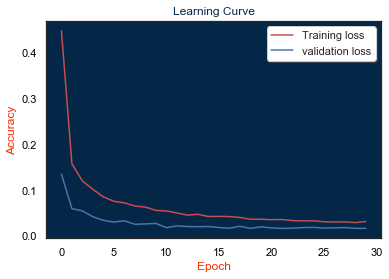

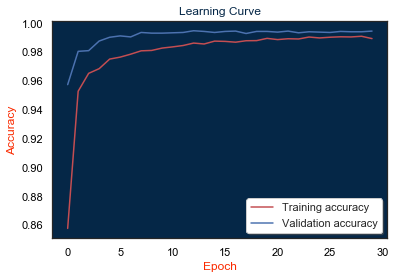

In [147]:
# Plot the loss and accuracy curves for training and validation 
fig, ax[0] = plt.subplots()
ax[0].plot(history.history['loss'], color='r', label="Training loss")
ax[0].plot(history.history['val_loss'], color='b', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)
# 2) hex string:
ax[0].set_facecolor('#052747')
# 3) gray level string:
ax[0].set_title('Learning Curve', color='#052747')
# 4) single letter color string
ax[0].set_xlabel('Epoch', color='#fa2a00')
# 5) a named color:
ax[0].set_ylabel('Accuracy', color='#fa2a00')
# 8) tab notation:
ax[0].tick_params(labelcolor='#000000')

fig, ax[1] = plt.subplots()
# 2) hex string:
ax[1].set_facecolor('#052747')
# 3) gray level string:
ax[1].set_title('Learning Curve', color='#052747')
# 4) single letter color string
ax[1].set_xlabel('Epoch', color='#fa2a00')
# 5) a named color:
ax[1].set_ylabel('Accuracy', color='#fa2a00')
# 8) tab notation:
ax[1].tick_params(labelcolor='#000000')
ax[1].plot(history.history['accuracy'], color='r', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='b',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 4.2 Confusion matrix

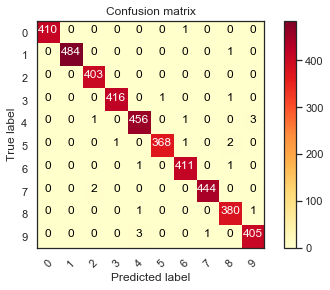

In [27]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.YlOrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

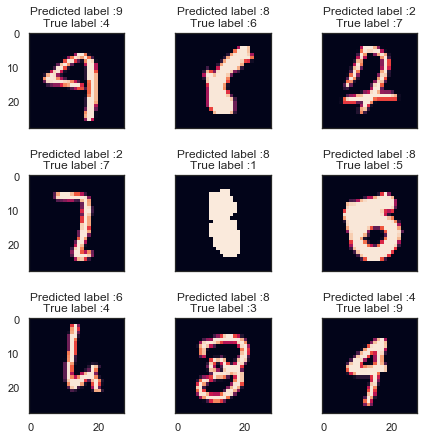

In [21]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 3
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(7,7))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 9 errors 
most_important_errors = sorted_dela_errors[-9:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## 4.3 Generate Results

In [22]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [23]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

# 5. Visualize the model

## 5.1 Visualize the metrix of first convolutional layer

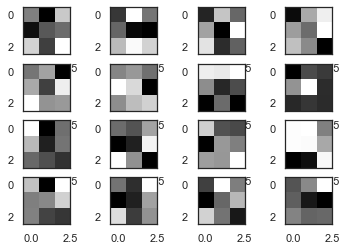

In [24]:
layer1 = model.layers[0]
layer1.name
conv2d_1w = layer1.get_weights()[0][:,:,0,:]
for i in range(1,17):
      plt.subplot(4,4,i)
      plt.imshow(conv2d_1w[:,:,i-1],interpolation="nearest",cmap="gray")
plt.show()

## 5.2 Visualize the output of convolutional and pooling layers

C:\Users\kcsstore.com\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=[<tf.Tenso...)`
  import sys
C:\Users\kcsstore.com\anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
C:\Users\kcsstore.com\anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


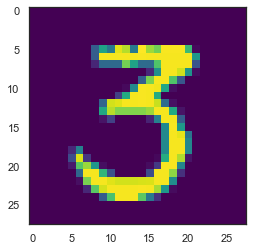

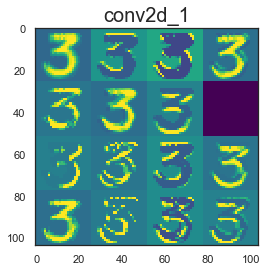

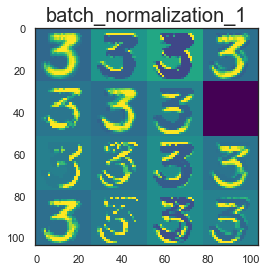

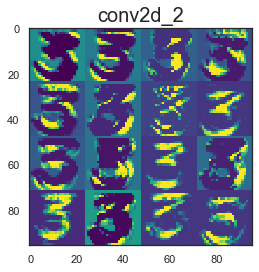

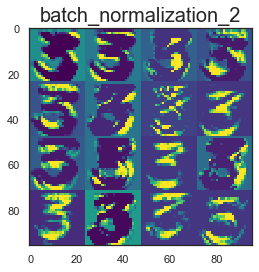

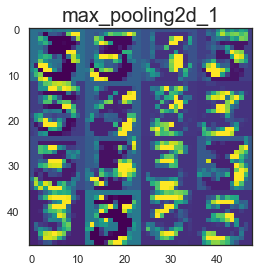

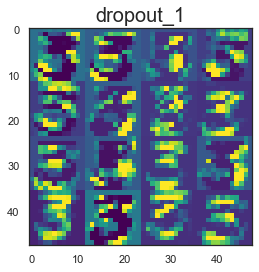

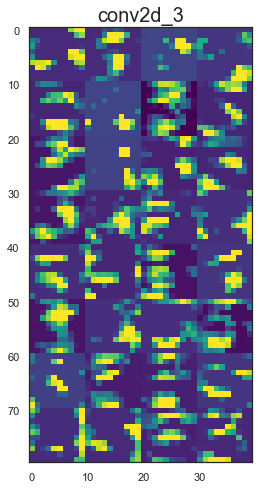

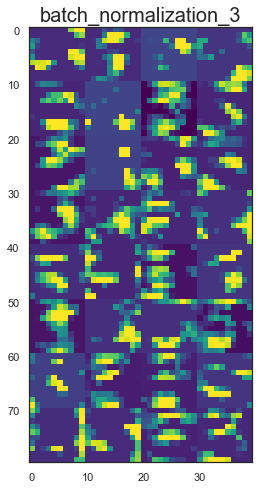

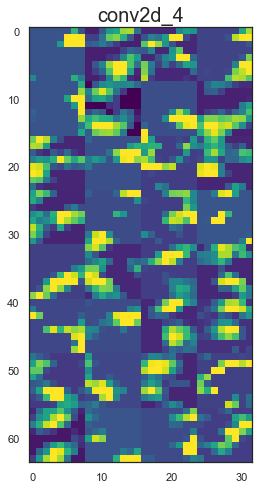

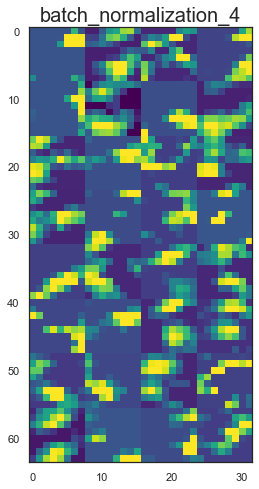

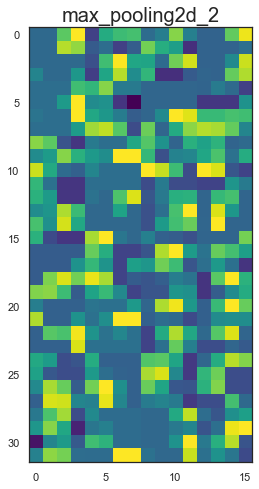

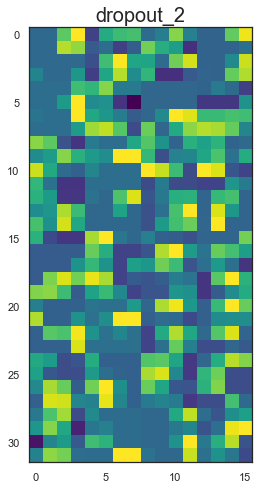

In [28]:
# visualize convolution and pool layer
test_im = x_train[3]
plt.imshow(test_im.reshape(28,28), cmap='viridis', interpolation='none')

# activation output
layer_outputs = [layer.output for layer in model.layers[:12]]
activation_model = models.Model(input=model.input, output=layer_outputs)
activations = activation_model.predict(test_im.reshape(1,28,28,1))

layer_names = []
for layer in model.layers:
    layer_names.append(layer.name) 
images_per_row = 4
for layer_name, layer_activation in zip(layer_names[:12], activations):
    #if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name, fontsize = 20)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')